In [1]:
import numpy as np
np.seterr(all='ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
matplotlib.use('TkAgg')
%matplotlib inline

from my_functions import *
from load_mocks import ensemble_mock
from minijpas_LF_and_puricomp import add_errors

from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

In [2]:
%matplotlib inline

In [3]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67
filter_tags = load_filter_tags()

In [4]:
field_name = 'minijpasAEGIS001'
name_qso = 'QSO_100000_0'
name_qso_bad = f'QSO_double_train_minijpas_DR16_D_0'
name_gal = f'GAL_LC_lines_0'
name_sf = f'LAE_12.5deg_z2-4.25_train_minijpas_0'

pm_flx, pm_err, zspec, EW_lya, L_lya, is_qso, is_sf, is_gal, is_LAE, where_hiL, _ = ensemble_mock(
    name_qso, name_gal, name_sf, name_qso_bad, add_errs=False)

pm_flx, pm_err = add_errors(pm_flx, apply_err=True,
                            survey_name='minijpasAEGIS001')

In [5]:
def load_STAR_prior_mock():
    ## Load QSO catalog
    filename = ('/home/alberto/cosmos/JPAS_mocks_sep2021/'
        'JPAS_mocks_classification_01sep_model11/Fluxes/Star_jpas_mock_flam_train.cat')

    my_filter_order = np.arange(60)
    my_filter_order[[-4, -3, -2, -1]] = np.array([1, 12, 28, 43])
    my_filter_order[1:-4] += 1
    my_filter_order[12:-4] += 1
    my_filter_order[28:-4] += 1
    my_filter_order[43:-4] += 1

    pm_flx = pd.read_csv(
        filename, sep=' ', usecols=range(2, 2 + 60)
    ).to_numpy().T[my_filter_order]
    pm_err = pd.read_csv(
        filename, sep=' ', usecols=range(2 + 60, 2 + 60 + 60)
    ).to_numpy().T[my_filter_order]
    zspec = pd.read_csv(filename, sep=' ', usecols=[127]).to_numpy().reshape(-1, )

    return pm_flx, pm_err

star_flx, star_err = load_STAR_prior_mock()

In [6]:
gal_area = 5.54
bad_qso_area = 200
good_qso_area = 400

# the proportional factors are made in relation to bad_qso
# so bad_qso_factor = 1
gal_factor = bad_qso_area / gal_area
good_qso_factor = bad_qso_area / good_qso_area

In [8]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

N_sources = pm_flx.shape[1]
N_sources
print(f'qso {count_true(is_qso)}')
print(f'sf {count_true(is_sf)}')
print(f'gal {count_true(is_gal)}')

qso 359052
sf 687653
gal 201497


In [9]:
ew0_cut = 30
ew_other = 400

# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, ew0_cut)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, cont_est_lya, first=True, return_line_width=True, qso_err=pm_err
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    ew_other, obs=True)
other_lines = identify_lines(line_other, cont_est_other, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.16

# %xdel cont_est_other
%xdel cont_err_other

In [10]:
mag_min = 17
mag_max = 24

nb_min = 1
nb_max = 4

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1
print(f'z interval: ({z_min:0.2f}, {z_max:0.2f})')

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
mag_cut = (mag > mag_min) & (mag < mag_max)

snr = np.empty(N_sources)
for src in range(N_sources):
    l = lya_lines[src]
    snr[src] = pm_flx[l, src] / pm_err[l, src]

nice_lya_mask = z_cut & mag_cut & (snr > 6)
nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr, mask=nice_lya_mask
)

z interval: (2.05, 2.44)


In [11]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

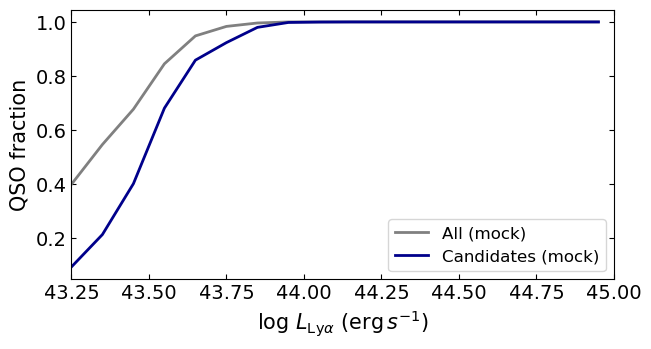

In [12]:
fig, ax = plt.subplots(figsize=(7, 3.5))

bins = np.linspace(43, 45, 21)
b_c = [bins[i: i + 2].sum() * 0.5 for i in range(len(bins) - 1)]

h_sf = np.histogram(L_Arr[nice_lya & nice_z & is_sf], bins)[0]
h_qso = np.histogram(L_Arr[nice_lya & nice_z & is_qso], bins)[0] * good_qso_factor

h_sf_mock = np.histogram(L_lya[zspec_cut & is_sf], bins)[0]
h_qso_mock = np.histogram(L_lya[zspec_cut & is_qso], bins)[0] * good_qso_factor

ax.plot(b_c, h_qso_mock / (h_qso_mock + h_sf_mock), linewidth=2, color='gray', label='All (mock)')
ax.plot(b_c, h_qso / (h_qso + h_sf), linewidth=2, color='darkblue', label='Candidates (mock)')

ax.set_xlim(43.26, 45)

ax.set_ylabel('QSO fraction', fontsize=15)
ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$ (erg$\,s^{-1}$)', fontsize=15)

ax.tick_params(labelsize=14, direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xticks(np.arange(43.25, 45.25, 0.25))

ax.legend(fontsize=12)

fig.savefig(f'figures/QSO_fraction.pdf', bbox_inches='tight',
            facecolor='w', edgecolor='w')
plt.show()

In [13]:
def M_to_m(M, redshift, x, y, z):
    dL = cosmo.luminosity_distance(redshift).to(u.pc).value.reshape(-1, 1)
    return M + 5 * np.log10(dL) - 5
lc = np.load('/home/alberto/almacen/David_lightcone/LightCone_512_15sep2022.npy')
XX, YY, ZZ = lc['pos'].T
z = lc['redshift']
OII_flux = lc['FluxDust_OII3729']
Hbeta_flux = lc['FluxDust_Hbeta']
M_noline = lc['ObsMagDustNoLine']
M_line = lc['ObsMagDustLine']
pm_mag_line = M_to_m(M_line, z, XX, YY, ZZ).T
pm_flx_line = mag_to_flux(pm_mag_line, w_central.reshape(-1, 1))
pm_mag_noline = M_to_m(M_noline, z, XX, YY, ZZ).T
pm_flx_noline = mag_to_flux(pm_mag_noline, w_central.reshape(-1, 1))

136999
zspec = 3.21, z_Arr = 2.11
r = 21.76
EW_lya = 48.84384936150306
g-r = 0.26, r-i = -0.08, color = True
[]


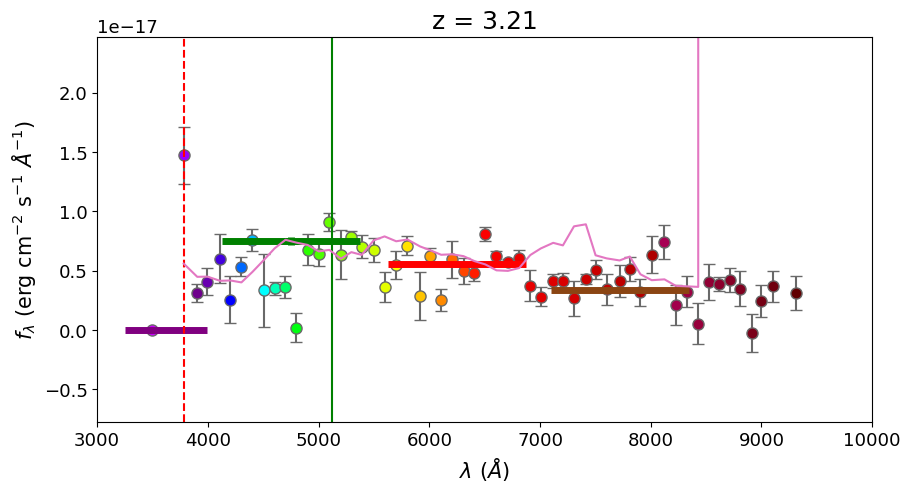

119554
zspec = 3.86, z_Arr = 2.11
r = 22.65
EW_lya = 107.26979239565986
g-r = 2.42, r-i = 0.04, color = False
[1, 22]


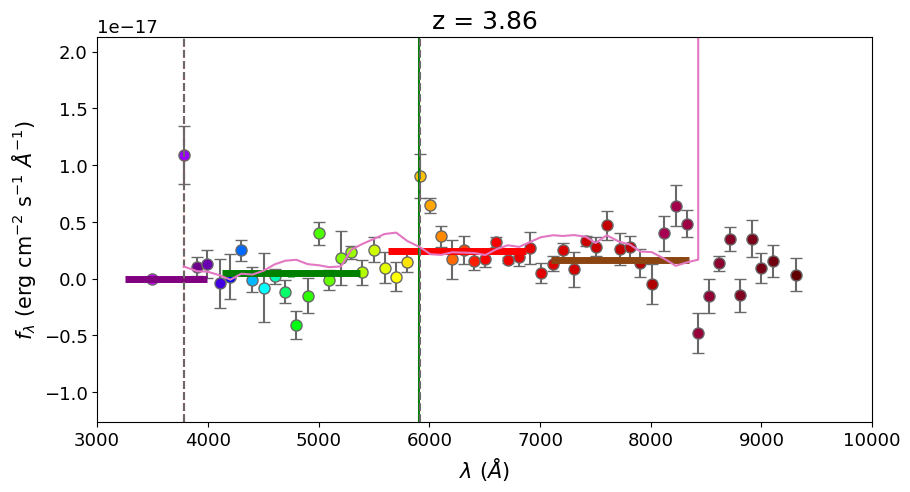

268198
zspec = 2.32, z_Arr = 2.29
r = 21.19
EW_lya = 79.32626438677062
g-r = -0.18, r-i = nan, color = False
[]


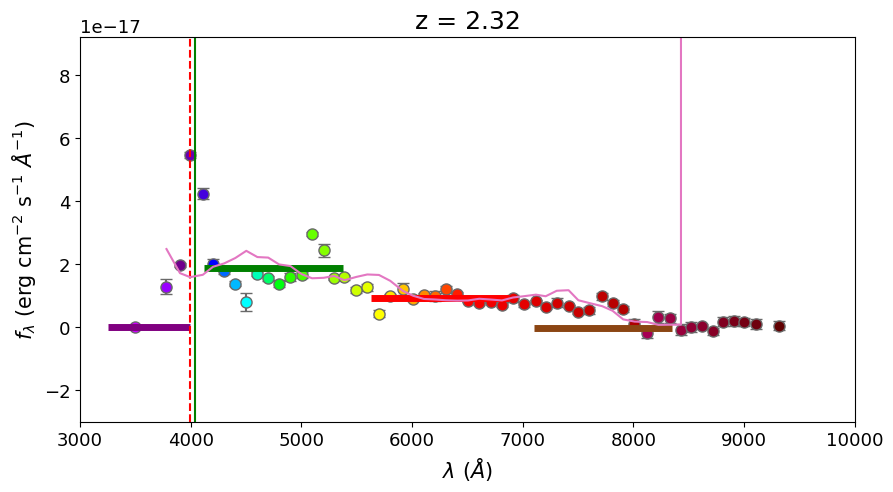

14687
zspec = 2.79, z_Arr = 2.11
r = 21.74
EW_lya = 53.91132784462462
g-r = 0.30, r-i = 0.28, color = True
[]


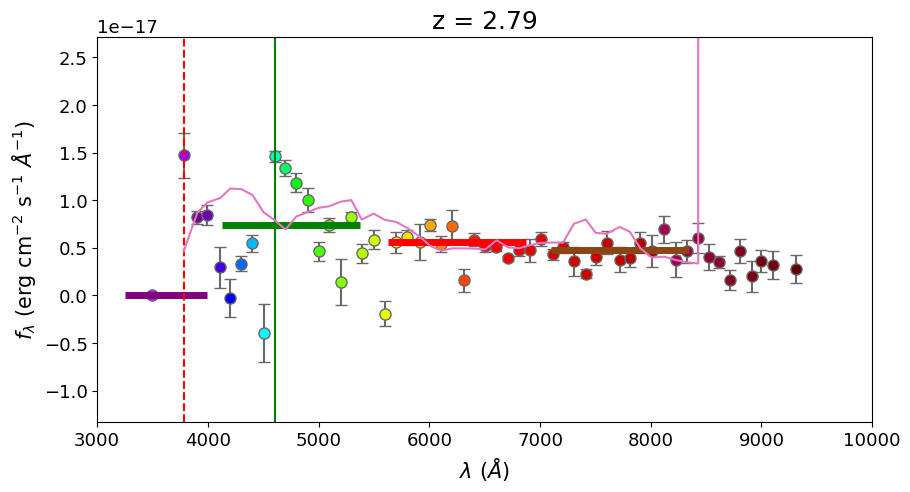

99218
zspec = 3.90, z_Arr = 2.11
r = 21.90
EW_lya = 112.2580688832217
g-r = 1.48, r-i = -0.12, color = False
[1]


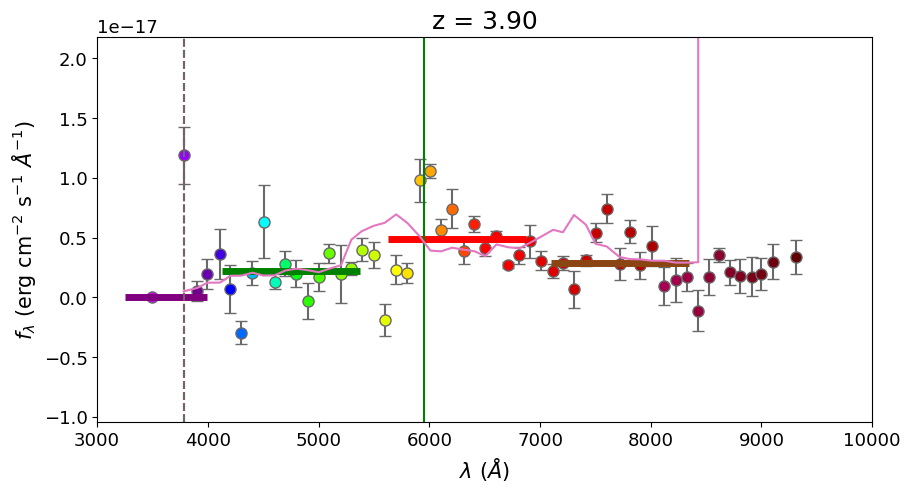

81826
zspec = 4.24, z_Arr = 2.38
r = 22.58
EW_lya = 63.50471748408558
g-r = 1.05, r-i = 0.60, color = False
[4, 12]


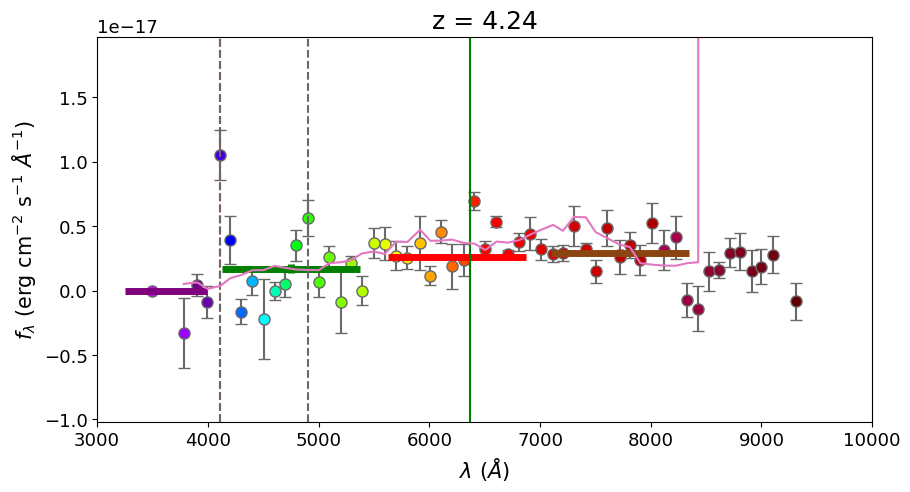

62158
zspec = 3.21, z_Arr = 2.11
r = 21.49
EW_lya = 33.875154440996084
g-r = 0.43, r-i = 0.46, color = True
[]


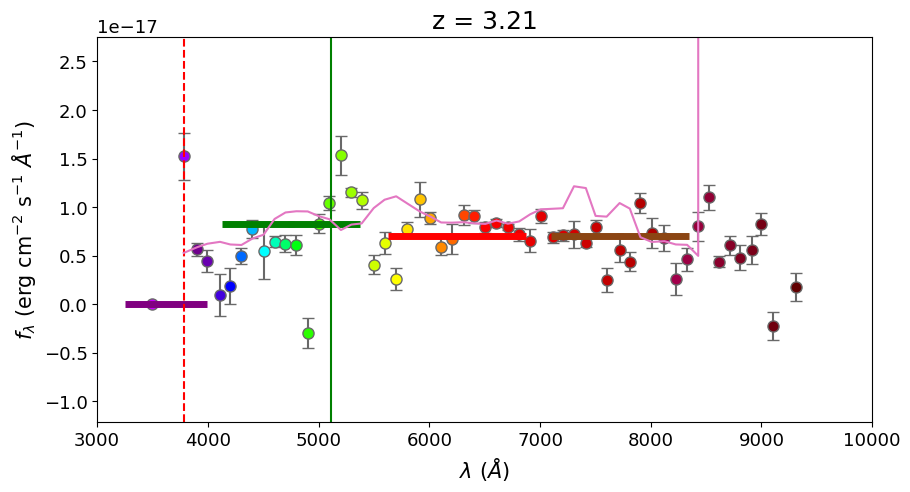

118946
zspec = 3.01, z_Arr = 2.11
r = 22.01
EW_lya = 431.0936765660709
g-r = 0.82, r-i = 0.53, color = True
[1]


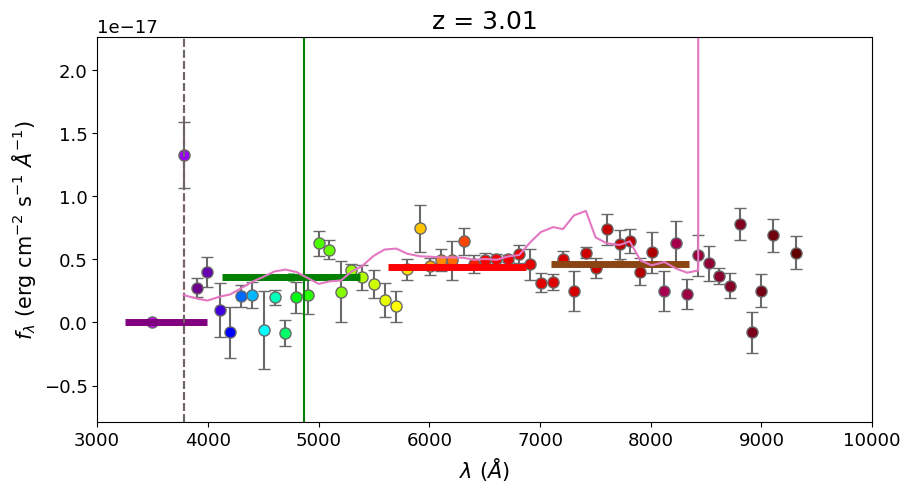

3037
zspec = 3.75, z_Arr = 2.38
r = 22.06
EW_lya = 96.15272080564942
g-r = 1.42, r-i = 0.22, color = False
[5]


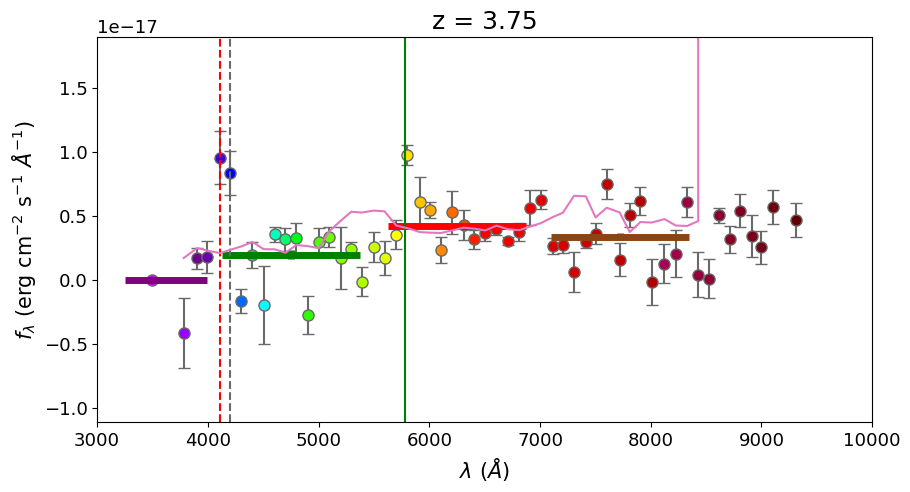

144341
zspec = 3.70, z_Arr = 2.29
r = 22.00
EW_lya = 60.08104622710361
g-r = nan, r-i = nan, color = False
[4]


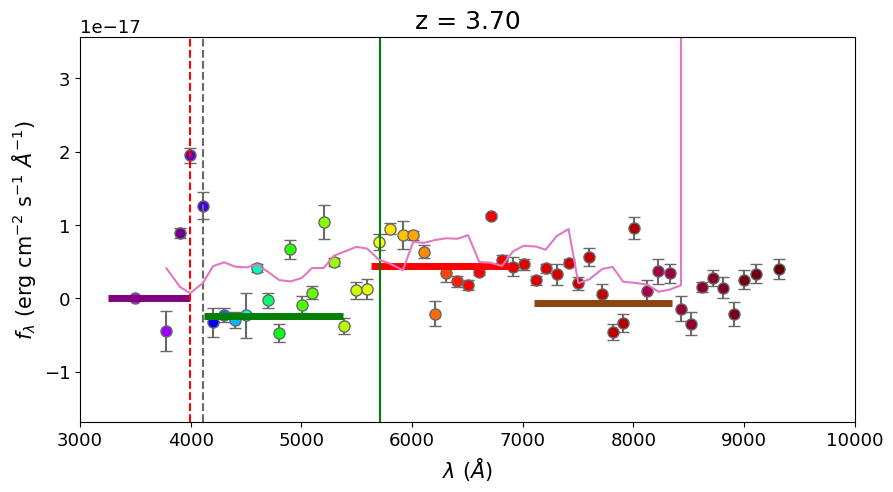

246064
zspec = 2.81, z_Arr = 2.11
r = 22.64
EW_lya = 158.73875657052463
g-r = 0.20, r-i = 0.31, color = True
[1]


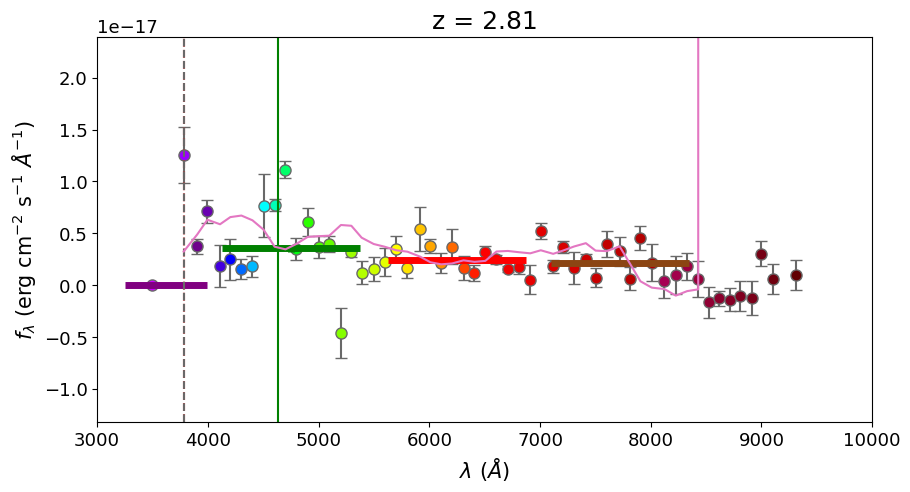

68575
zspec = 3.39, z_Arr = 2.38
r = 21.88
EW_lya = 81.79388196375349
g-r = 0.86, r-i = 0.19, color = True
[4]


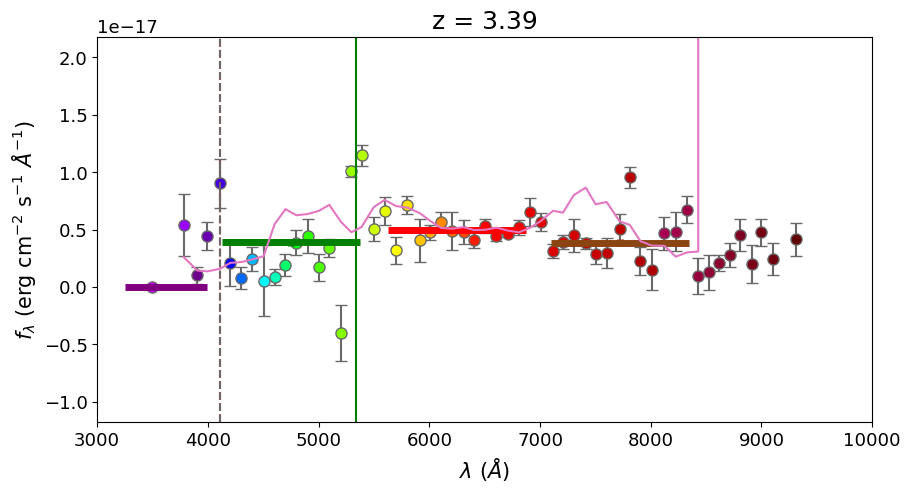

274208
zspec = 3.36, z_Arr = 2.38
r = 21.95
EW_lya = 155.54204796849115
g-r = 0.95, r-i = 0.42, color = True
[4]


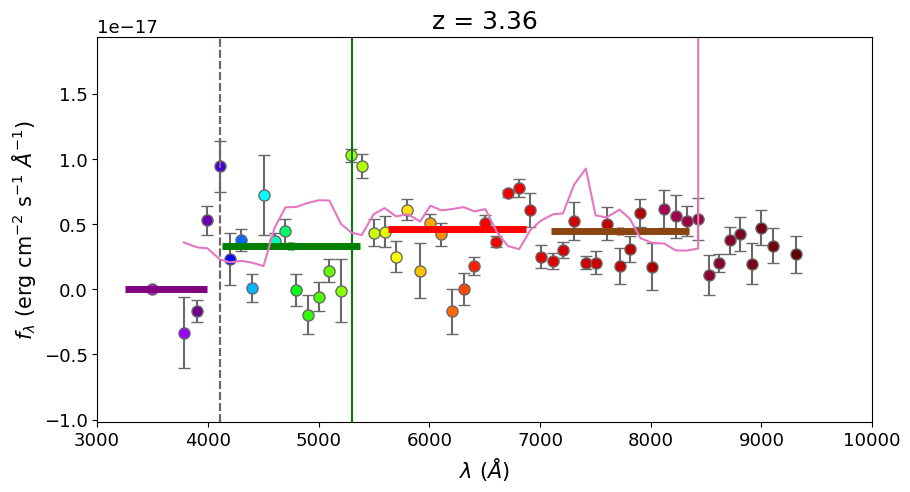

166252
zspec = 2.32, z_Arr = 2.29
r = 23.52
EW_lya = 81.32124903928131
g-r = -1.66, r-i = 1.63, color = False
[]


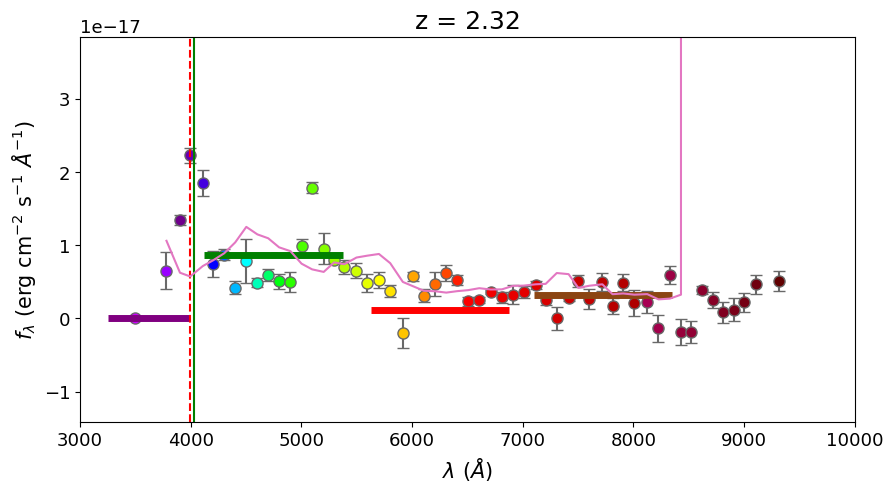

37259
zspec = 4.11, z_Arr = 2.11
r = 21.65
EW_lya = 231.0989750398765
g-r = 2.05, r-i = 0.30, color = False
[1]


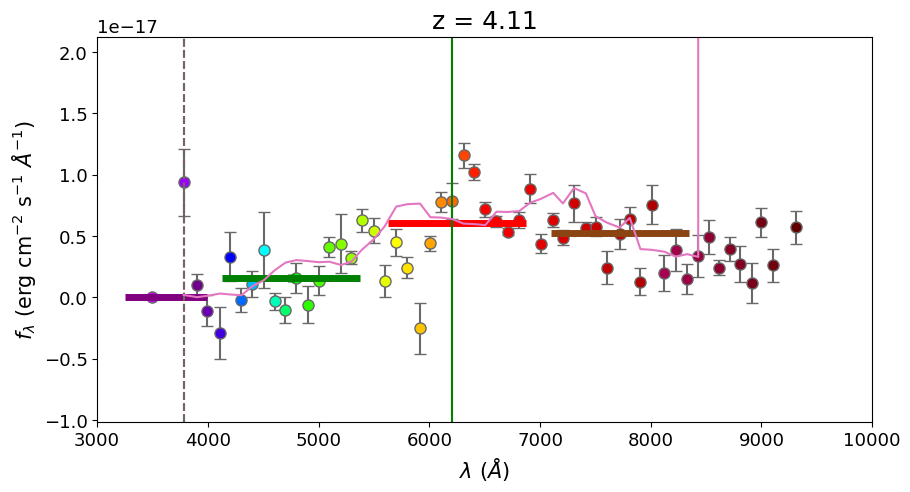

80025
zspec = 3.70, z_Arr = 2.29
r = 21.54
EW_lya = 60.08104622710361
g-r = 5.48, r-i = -1.44, color = False
[3]


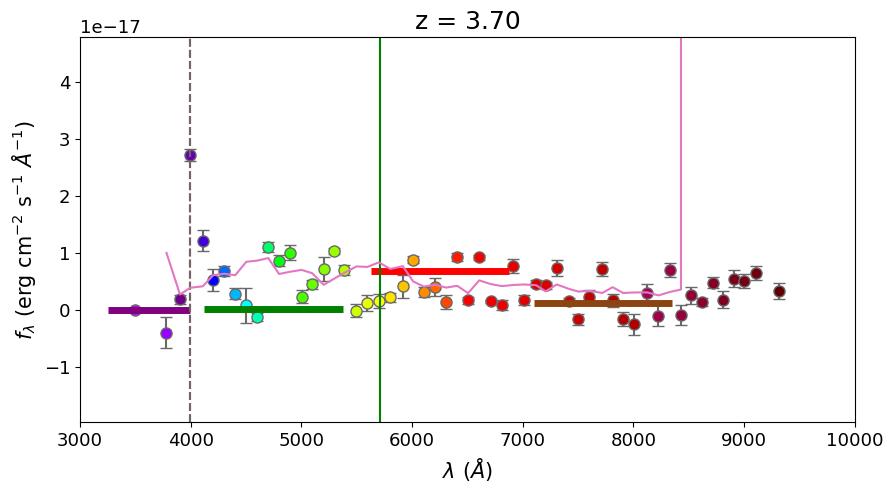

179282
zspec = 2.36, z_Arr = 2.29
r = 21.77
EW_lya = 225.71467840023712
g-r = 0.55, r-i = 0.78, color = False
[4]


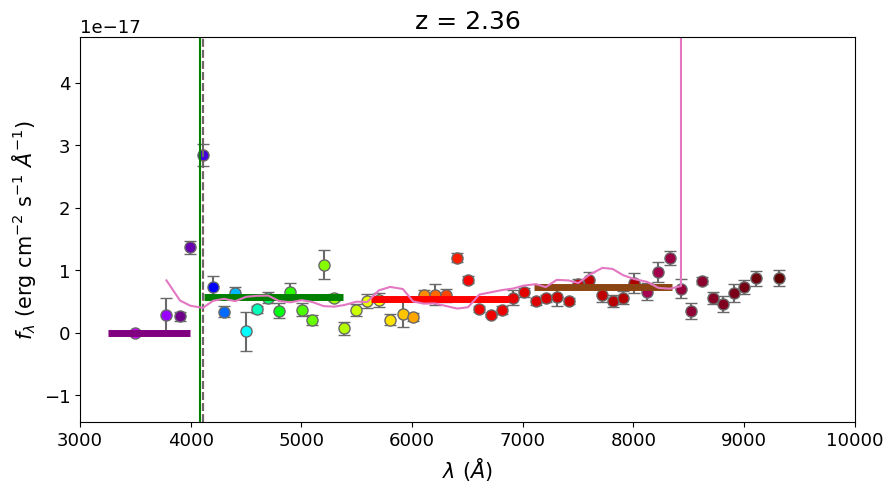

113952
zspec = 3.70, z_Arr = 2.38
r = 21.67
EW_lya = 34.46325799079641
g-r = 1.48, r-i = 0.44, color = False
[4]


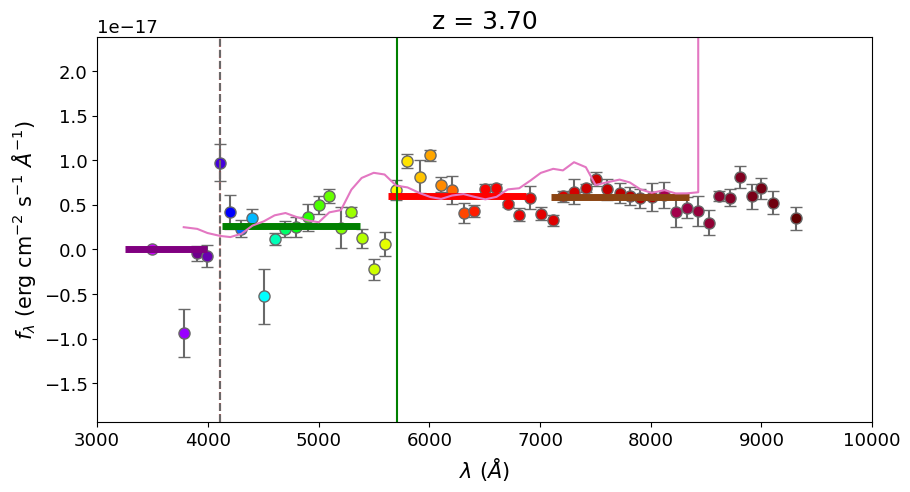

139566
zspec = 2.32, z_Arr = 2.29
r = 21.15
EW_lya = 79.32626438677062
g-r = -0.13, r-i = nan, color = False
[]


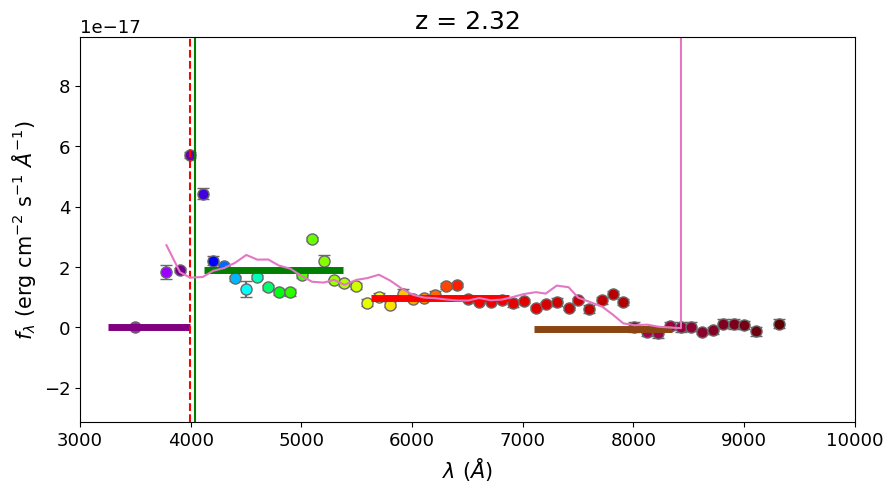

218989
zspec = 3.37, z_Arr = 2.38
r = 22.11
EW_lya = 91.31450434690942
g-r = 0.26, r-i = 0.33, color = True
[]


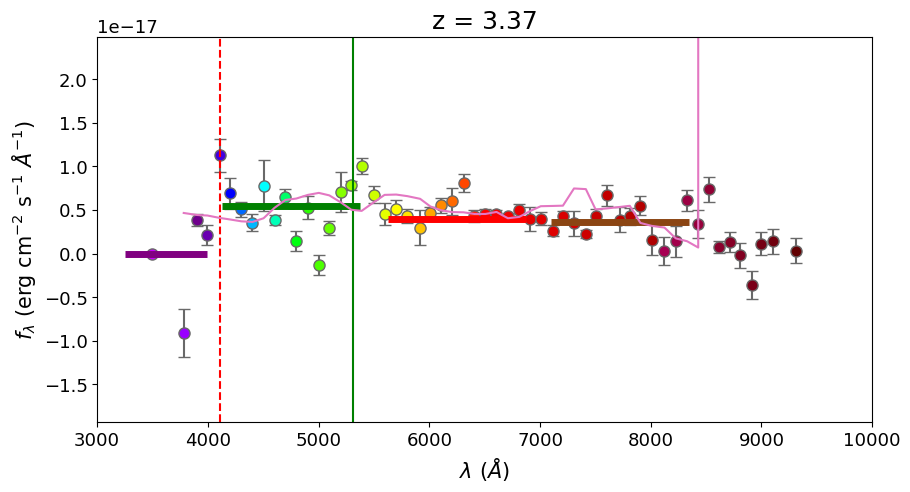

In [46]:
selected = np.random.permutation(
    np.where(
        is_qso & (L_lya > 44) & ~nice_lya & z_cut
    )[0]
)

qso_lines = [1025.7220, 1397.61, 1549.48, 1908.73, 2799.12]
# Actually gal lines
# qso_lines = [3727, 4861, 5007, 6549, 6585]
# qso_lines_name = ['OII', r'H$\beta$', 'OIII', r'H$\alpha$']
pm_flx[0, :] = 0
pm_flx[-4, :] = 0
pm_err[0, :] = 0
pm_err[-4, :] = 0

ii = flux_to_mag(pm_flx[-1], w_central[-1])
rr = flux_to_mag(pm_flx[-2], w_central[-2])
gg = flux_to_mag(pm_flx[-3], w_central[-3])
ri = rr - ii
gr = gg - rr
color_aux2 = (-1.5 * ri + 1.7 > gr) & (ri < 1.) & (gr < 1.)

gal_src = np.where(is_gal)[0]
for i, src in enumerate(selected):
    if i == 20:
        break
    print(src)
    print(f'zspec = {zspec[src]:0.2f}, z_Arr = {z_Arr[src]:0.2f}')
    print(f'r = {mag[src]:0.2f}')
    print(f'EW_lya = {EW_lya[src]}')
    print(f'g-r = {(gg-rr)[src]:0.2f}, r-i = {(rr-ii)[src]:0.2f}, color = {color_aux2[src]}')
    lya_obs_w = w_central[lya_lines[src]]
    other_lines_w = [w_central[i] for i in other_lines[src]]
    lya_real_w = w_lya * (1 + zspec[src])

    fig = plt.figure(figsize=(10, 5))
    ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src]) 

    ax.axvline(lya_obs_w, linestyle='--', color='r', label='Retrieved Lya line')
    ax.axvline(lya_real_w, color='g', label='Real Lya line')
    for w in other_lines_w:
        ax.axvline(w, linestyle='--', color='dimgray')
    # for name, w in zip(qso_lines_name, qso_lines):
    #     qso_obs_w = w * (1 + zspec[src])
    #     ax.axvline(qso_obs_w, linestyle=':', color='orange')
    #     ypos = pm_flx_line[:, np.where(gal_src == src)[0][0]].min() * 1e17
    #     ax.text(qso_obs_w, ypos, name)
    print(other_lines[src])

    ax.plot(w_central[1:53], cont_est_lya[1:-3, src])
    # ax.plot(w_central[1:54], cont_est_other[1:-2, src], ls='--')

    ax.set_title(f'zspec={zspec[src]:0.3f}, z_Arr={z_Arr[src]:0.3f}')

    # ax.set_ylim((-0.25, 5))
    ax.set_xlim((3000, 10000))
    ax.set_title(f'z = {zspec[src]:0.2f}', fontsize=18)

    plt.show()


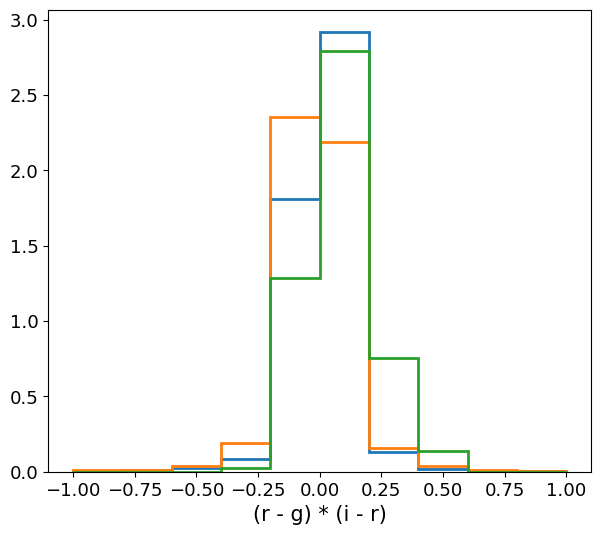

In [15]:
def do_this():
    i = flux_to_mag(pm_flx[-1], w_central[-1])
    r = flux_to_mag(pm_flx[-2], w_central[-2])
    g = flux_to_mag(pm_flx[-3], w_central[-3])
    gr_err = (pm_err[-1] ** 2 + pm_err[-2] ** 2) ** 0.5

    fig, ax = plt.subplots(figsize=(7, 6))

    where = (nice_lya & is_qso & nice_z)
    bins = np.linspace(-1, 1, 11)
    to_hist = ((r - g) * (i - r))[where]
    ax.hist(to_hist, bins, histtype='step', density=True, linewidth=2)
    
    where = (nice_lya & is_sf & nice_z)
    to_hist = ((r - g) * (i - r))[where]
    ax.hist(to_hist, bins, histtype='step', density=True, linewidth=2)

    where = (nice_lya & is_gal)
    to_hist = ((r - g) * (i - r))[where]
    ax.hist(to_hist, bins, histtype='step', density=True, linewidth=2)

    ax.set_xlabel('(r - g) * (i - r)', fontsize=15)

    plt.show()

do_this()

In [16]:
def contour_curve(xx, yy, bins_xx, bins_yy):
    Z, x, y = np.histogram2d(xx, yy, bins=(bins_xx, bins_yy))

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * ( y[1:] + y[:-1] )
    x_centers = 0.5 * ( x[1:] + x[:-1] )

    N_bins = 10000

    H_Arr = np.linspace(H_min , H_max , N_bins)[::-1]

    fact_up_Arr = np.zeros( N_bins )

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
    H_value_90 = np.interp(0.900, fact_up_Arr, H_Arr) # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma
    # levels = [H_value_99]
    levels = [H_value_90, H_value_68]

    return x_centers, y_centers, Z.T, levels

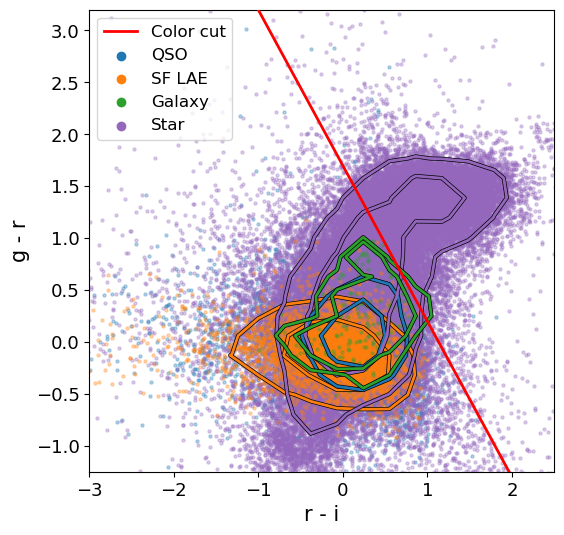

In [17]:
def do_this(c1, c2, c1_star, c2_star, xlabel, ylabel, xlims, ylims, curve=None):
    c1[~np.isfinite(c1)] = 99.
    c2[~np.isfinite(c2)] = 99.
    c1_star[~np.isfinite(c1_star)] = 99.
    c2_star[~np.isfinite(c2_star)] = 99.

    fig, ax = plt.subplots(figsize=(6, 6))

    bins_xx = np.linspace(-5.5, 3.5, 30)
    bins_yy = np.linspace(-2.5, 3, 30)

    where = (is_qso & zspec_cut & nice_lya)
    x = c1[where]
    y = c2[where]
    x_centers, y_centers, Z, levels = contour_curve(x, y, bins_xx, bins_yy)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='C0', linewidths=2, zorder=22)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='k', linestyles='-', linewidths=3, zorder=21)
    ax.scatter(x, y, alpha=0.3, s=5, zorder=1, rasterized=True)

    where = (is_sf & zspec_cut & nice_lya)
    x = c1[where]
    y = c2[where]
    x_centers, y_centers, Z, levels = contour_curve(x, y, bins_xx, bins_yy)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='C1', linewidths=2, zorder=12)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='k', linestyles='-', linewidths=3, zorder=11)
    ax.scatter(x, y, alpha=0.3, s=5, zorder=2, rasterized=True)

    where = (is_gal & nice_lya)
    x = c1[where]
    y = c2[where]
    x_centers, y_centers, Z, levels = contour_curve(x, y, bins_xx, bins_yy)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='C2', linewidths=2, zorder=32)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='k', linestyles='-', linewidths=3, zorder=31)
    ax.scatter(x, y, alpha=0.3, s=5, zorder=3, rasterized=True)

    x = c1_star
    y = c2_star
    x_centers, y_centers, Z, levels = contour_curve(x, y, bins_xx, bins_yy)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='C4', linewidths=2, zorder=22)
    ax.contour(x_centers, y_centers, Z, levels=levels,
               colors='k', linestyles='-', linewidths=3, zorder=21)
    ax.scatter(x, y, alpha=0.3, s=5, c='C4', zorder=1, rasterized=True)

    if curve is not None:
        x = np.linspace(-10, 10, 1000)
        ax.plot(x, curve(x), color='red', linewidth=2,
                label='Color cut', zorder=99)

    # Dummy points for the legend
    ax.scatter(99, 99, c='C0', label='QSO')
    ax.scatter(99, 99, c='C1', label='SF LAE')
    ax.scatter(99, 99, c='C2', label='Galaxy')
    ax.scatter(99, 99, c='C4', label='Star')

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend(fontsize=12)

    filename = 'figures/ColorColor_contaminants.pdf'
    fig.savefig(filename, format='pdf', bbox_inches='tight',
                facecolor='w', edgecolor='w', backend='PDF')
    plt.show()


i = flux_to_mag(pm_flx[-1], w_central[-1])
r = flux_to_mag(pm_flx[-2], w_central[-2])
g = flux_to_mag(pm_flx[-3], w_central[-3])

i_star = flux_to_mag(star_flx[-1], w_central[-1])
r_star = flux_to_mag(star_flx[-2], w_central[-2])
g_star = flux_to_mag(star_flx[-3], w_central[-3])

c1 = r - i
c2 = g - r

c1_star = r_star - i_star
c2_star = g_star - r_star

xlabel = 'r - i'
ylabel = 'g - r'
xlims = [-3, 2.5]
ylims = [-1.25, 3.2]
def curve(x): return -1.5 * x + 1.7


do_this(c1, c2, c1_star, c2_star, xlabel, ylabel, xlims, ylims, curve)

# c1 = i - u
# c2 = r - i
# xlabel = 'i - J1007'
# ylabel = 'r - i'
# xlims = [-3, 3]
# ylims = [-2, 2]
# def curve(x): return 0 * x

# do_this(c1, c2, xlabel, ylabel, xlims, ylims)


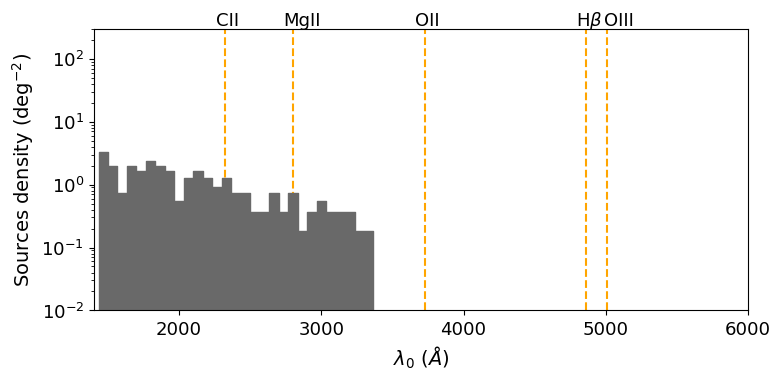

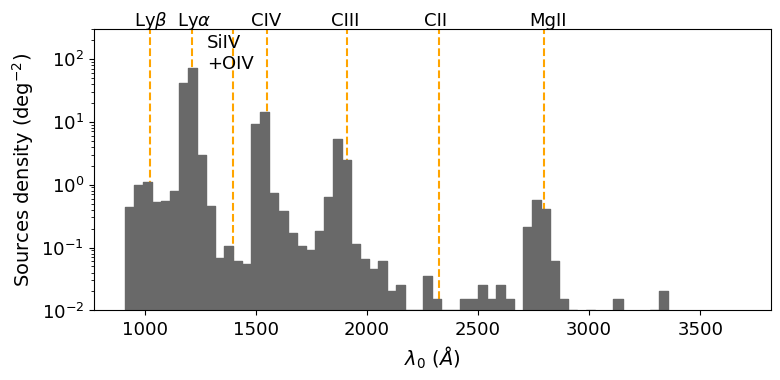

In [18]:
def do_this(maskkk):
    fig, ax = plt.subplots(figsize=(8, 4))

    mask = nice_lya & is_gal & z_cut & maskkk
    w0 = w_central[lya_lines[mask]] / (1 + zspec[mask])

    bin_min = 1400
    bin_max = 6000
    bins = np.linspace(bin_min, bin_max, 70)
    bins_c = [bins[i: i + 2].sum() * 0.5 for i in range(len(bins) - 1)]

    hist, _ = np.histogram(w0, bins)
    ax.fill_between(bins_c, hist * gal_factor / 200, step='pre', color='dimgray')

    gal_line_w = [2799, 4861, 3727, 5008, 2326]
    gal_line_name = ['MgII', r'H$\beta$', 'OII', 'OIII', 'CII']
    for w, name in zip(gal_line_w, gal_line_name):
        ax.axvline(w, color='orange', linestyle='--', zorder=-99)
        if name != 'OIII':
            ax.text(w - 70, 340, name, fontsize=13)
        else:
            ax.text(w - 20, 340, name, fontsize=13)

    ax.set_xlim(bin_min, bin_max)
    ax.set_ylim(1e-2, 300)
    ax.set_yscale('log')
    ax.set_xlabel('$\lambda_0$ ($\AA$)', fontsize=14)
    ax.set_ylabel('Sources density (deg$^{-2})$', fontsize=14)

    fig.tight_layout()
    # fig.savefig(f'figures/GAL_contaminants_w0_hist_ew0min{ew0_cut}.pdf', bbox_inches='tight',
    #             facecolor='w', edgecolor='w')
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 4))

    bins = np.linspace(890, 3700, 70)
    bins_c = [bins[i: i + 2].sum() * 0.5 for i in range(len(bins) - 1)]

    mask = nice_lya & is_qso & (zspec < 2) & maskkk
    w0 = w_central[lya_lines[mask]] / (1 + zspec[mask])
    hbad, _ = np.histogram(w0, bins)
    mask = nice_lya & is_qso & (zspec > 2)
    w0 = w_central[lya_lines[mask]] / (1 + zspec[mask])
    hgood, _ = np.histogram(w0, bins)

    ax.fill_between(bins_c, (hbad + hgood * 0.5) / 200, step='pre', color='dimgray')

    qso_line_w = [1549.48, 1908.73, 2799.12, 2326.00, 1215.67, 1025, 1399.8]
    qso_line_name = ['CIV', 'CIII', 'MgII', 'CII', r'Ly$\alpha$', r'Ly$\beta$', 'SiIV\n+OIV']

    for w, name in zip(qso_line_w, qso_line_name):
        ax.axvline(w, color='orange', linestyle='--', zorder=-99)
        if name != 'SiIV\n+OIV':
            ax.text(w - 70, 340, name, fontsize=13)
        else:
            ax.text(w - 120, 70, name, fontsize=13)

    ax.set_yscale('log')
    ax.set_xlabel('$\lambda_0$ ($\AA$)', fontsize=14)
    ax.set_ylabel('Sources density (deg$^{-2})$', fontsize=14)
    ax.set_ylim(1e-2, 300)

    fig.tight_layout()
    # fig.savefig(f'figures/QSO_contaminants_w0_hist_ew0min{ew0_cut}.pdf', bbox_inches='tight',
    #             facecolor='w', edgecolor='w')
    plt.show()

do_this((mag < 24) & (mag > 17))

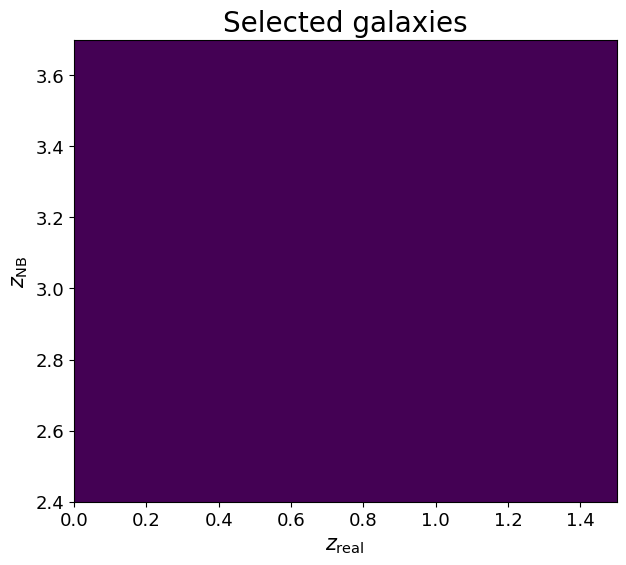

In [19]:
def do_this():
    fig, ax = plt.subplots(figsize=(7, 6))

    xx = zspec[is_gal & nice_lya]
    yy = z_Arr[is_gal & nice_lya]
    bins2d = [np.linspace(0, 1.5, 30), np.linspace(2.4, 3.7, 30)]

    ax.hist2d(xx, yy, bins2d)
    
    ax.set_ylabel(r'$z_\mathrm{NB}$', fontsize=15)
    ax.set_xlabel(r'$z_\mathrm{real}$', fontsize=15)

    ax.set_title('Selected galaxies', fontsize=20)

    plt.show()

do_this()

In [20]:
# Probability of a source being randomly selected is 0.003
print(count_true(is_gal & (lya_lines == 9)) /
      count_true(is_gal))

0.0004962853044958485


In [21]:
EW_Arr = np.empty(L_Arr.shape)
for src in range(N_sources):
    l = lya_lines[src]
    EW_Arr[src] = (pm_flx[l, src] / cont_est_lya[l, src] - 1) * nb_fwhm_Arr[l]

(16,) 15


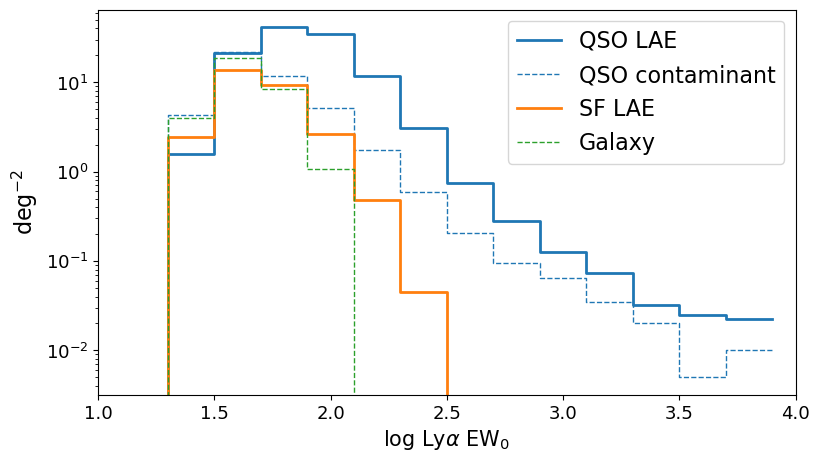

In [22]:
def do_this():
    fig, ax = plt.subplots(figsize=(9, 5))

    bins = np.linspace(1, 4, 15 + 1)
    bins_c = [bins[i: i + 2].sum() * 0.5 for i in range(len(bins) - 1)]
    print(bins.shape, len(bins_c))
    mag_max = 24
    

    log_EW0_Arr = np.log10(EW_Arr / (1 + z_Arr))

    mask = is_qso & nice_lya & nice_z & (mag < mag_max)
    hist, _ = np.histogram(log_EW0_Arr[mask], bins=bins)
    ax.step(bins_c, hist / good_qso_area,
            label='QSO LAE', color='C0', linewidth=2)

    mask = is_qso & nice_lya & ~nice_z & (mag < mag_max)
    hist, _ = np.histogram(log_EW0_Arr[mask], bins=bins)
    ax.step(bins_c, hist / bad_qso_area, label='QSO contaminant', color='C0',
            linewidth=1, linestyle='--')

    mask = is_sf & nice_lya & nice_z & (mag < mag_max)
    hist, _ = np.histogram(log_EW0_Arr[mask], bins=bins)
    ax.step(bins_c, hist / bad_qso_area, label='SF LAE', color='C1', linewidth=2)

    mask = is_gal & nice_lya & (mag < mag_max)
    hist, _ = np.histogram(log_EW0_Arr[mask], bins=bins)
    ax.step(bins_c, hist / gal_area, label='Galaxy',
            color='C2', linestyle='--', linewidth=1)

#     ax.axvline(np.log10(15), color='orange', linestyle='--')

    ax.set_xlabel(r'log Ly$\alpha$ EW$_0$', fontsize=15)
    ax.set_ylabel('deg$^{-2}$', fontsize=16)
    ax.legend(fontsize=16)

    ax.set_yscale('log')

#     ax.set_ylim(1, 3e3)
    ax.set_xlim(1, 4)

    N_sel = (
        count_true(nice_lya & is_sf)
        + count_true(nice_lya & is_qso & is_LAE) * good_qso_factor
        + count_true(nice_lya & is_qso & ~is_LAE)
        + count_true(nice_lya & is_gal) * gal_factor
    )
    to_save_hist = (
        np.histogram(log_EW0_Arr[nice_lya & is_sf & nice_z], bins)[0]
        + np.histogram(log_EW0_Arr[nice_lya & is_qso & nice_z], bins)[0] * good_qso_factor
    ) / N_sel
    np.save(f'npy/Expected_EW_hist.npy', to_save_hist)
    cont_hist = (
        np.histogram(log_EW0_Arr[nice_lya & is_qso & ~nice_z], bins)[0]
        + np.histogram(log_EW0_Arr[nice_lya & is_gal], bins)[0] * gal_factor
    ) / N_sel
    np.save(f'npy/Cont_EW_hist.npy', cont_hist)

do_this()